<a href="https://colab.research.google.com/github/csprout3/MLoCoMo/blob/main/colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## MLOCOMO: TED Talk Processing for Multimodal Memory Evaluation

This notebook processes Brené Brown's "The Power of Vulnerability" TED talk into MLOCOMO format.

 **What you'll get:**
 - ~74 video segments with multimodal annotations
 - ~45 QA pairs across all recall types and modality combinations  
 - Complete dataset ready for memory evaluation

**Estimated time:** 15-20 minutes
**Estimated cost:** ~$3 in OpenAI API calls


In [1]:
# =============================================================================
# SECURE API KEY SETUP FOR GOOGLE COLAB
# =============================================================================

import os
import sys

def setup_colab_environment():
    """Set up environment for Google Colab with secure API key handling"""

    # Method 1: Try Colab userdata (most secure)
    try:
        from google.colab import userdata
        api_key = userdata.get('OPENAI_API_KEY')
        if api_key:
            os.environ['OPENAI_API_KEY'] = api_key
            print("✅ API key loaded from Colab userdata")
            return api_key
    except Exception as e:
        print(f"⚠️  Could not load from Colab userdata: {e}")
        print("�� To set up userdata: Click the key icon (🔑) in left sidebar")

    # Method 2: Manual input (fallback)
    import getpass
    api_key = getpass.getpass("Enter your OpenAI API key: ")
    os.environ['OPENAI_API_KEY'] = api_key
    print("✅ API key set from manual input")
    return api_key

# Set up the environment
OPENAI_API_KEY = setup_colab_environment()

✅ API key loaded from Colab userdata


In [2]:
# Install required packages
!pip install -q openai
!pip install -q openai-whisper
!pip install -q yt-dlp
!pip install -q sentence-transformers
!pip install -q tqdm
!pip install -q opencv-python
!pip install -q matplotlib
!pip install -q ipython


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 803.2/803.2 kB 16.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 177.1/177.1 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 68.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 34.8 MB/s eta 0:00:00


In [3]:
# Import libraries
import json
import asyncio
import os
import subprocess
import logging
import time
import base64
from pathlib import Path
from typing import Dict, List, Optional, Any, Tuple
from dataclasses import dataclass, asdict
import uuid
from datetime import datetime, timedelta

import cv2
import numpy as np
import whisper
import openai
from sentence_transformers import SentenceTransformer
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from IPython.display import Video, Audio, Image, HTML, display, clear_output

print("✅ All packages installed successfully!")

✅ All packages installed successfully!


In [4]:
# Check for required packages
required_packages = ['openai', 'whisper', 'cv2', 'sentence_transformers', 'tqdm']
missing_packages = []

for package in required_packages:
    try:
        if package == 'cv2':
            import cv2
        elif package == 'whisper':
            import whisper
        elif package == 'sentence_transformers':
            from sentence_transformers import SentenceTransformer
        else:
            __import__(package)
        print(f"✅ {package}")
    except ImportError:
        print(f"❌ {package}")
        missing_packages.append(package)

if missing_packages:
    print(f"\n⚠️  Missing packages: {missing_packages}")
    print("Run the pip install cell above first!")
else:
    print("\n✅ All required packages are available!")

✅ openai
✅ whisper
✅ cv2
✅ sentence_transformers
✅ tqdm

✅ All required packages are available!


## Step 2: Configuration

In [5]:
# Configuration
OPENAI_API_KEY = OPENAI_API_KEY

# Validate API key
if not OPENAI_API_KEY:
    print("⚠️  Please enter your OpenAI API key above and run this cell again")
    print("Get your API key from: https://platform.openai.com/api-keys")
else:
    # Test API key
    try:
        client = openai.OpenAI(api_key=OPENAI_API_KEY)
        # Simple test call
        test_response = client.chat.completions.create(
            model="gpt-4o-mini",
            messages=[{"role": "user", "content": "Hello"}],
            max_tokens=5
        )
        print("✅ OpenAI API key validated successfully!")
    except Exception as e:
        print(f"❌ API key validation failed: {e}")
        OPENAI_API_KEY = None


✅ OpenAI API key validated successfully!


## Step 3: Load Models and Setup

In [6]:
class MLOCOMOProcessor:
    """MLOCOMO processor optimized for Google Colab"""

    def __init__(self, api_key: str):
        self.client = openai.OpenAI(api_key=api_key)
        self.setup_complete = False

        # TED Talk configuration
        self.video_config = {
            "url": "https://www.youtube.com/watch?v=iCvmsMzlF7o",
            "title": "Brené Brown: The Power of Vulnerability",
            "duration": 1260,  # ~21 minutes
            "license": "CC BY-NC-ND 4.0"
        }

    def setup_models(self):
        """Setup models with progress tracking"""
        print("🔄 Setting up models...")

        # Load Whisper
        try:
            print("Loading Whisper model...")
            self.whisper_model = whisper.load_model("base")
            print("✅ Whisper loaded")
        except Exception as e:
            print(f"⚠️  Whisper failed, will use OpenAI API: {e}")
            self.whisper_model = None

        # Load sentence transformer
        try:
            print("Loading sentence transformer...")
            self.sentence_model = SentenceTransformer('all-MiniLM-L6-v2')
            print("✅ Sentence transformer loaded")
        except Exception as e:
            print(f"⚠️  Sentence transformer failed: {e}")
            self.sentence_model = None

        self.setup_complete = True
        print("🎉 Setup complete!")

    def download_video(self) -> str:
        """Download TED talk video"""
        print("📥 Downloading TED talk...")

        output_path = "ted_talk.mp4"

        cmd = [
            "yt-dlp",
            "--format", "best[height<=720][ext=mp4]/best[ext=mp4]",
            "--output", output_path,
            self.video_config["url"]
        ]

        try:
            # Show progress
            process = subprocess.Popen(
                cmd, stdout=subprocess.PIPE, stderr=subprocess.STDOUT,
                universal_newlines=True, bufsize=1
            )

            for line in process.stdout:
                if "%" in line and "ETA" in line:
                    clear_output(wait=True)
                    print(f"📥 Downloading: {line.strip()}")

            process.wait()

            if process.returncode == 0 and os.path.exists(output_path):
                print("✅ Download complete!")
                return output_path
            else:
                raise RuntimeError("Download failed")

        except Exception as e:
            print(f"❌ Download failed: {e}")
            raise

    def extract_audio(self, video_path: str) -> str:
        """Extract audio from video"""
        print("🎵 Extracting audio...")

        audio_path = "audio.wav"

        cmd = [
            "ffmpeg", "-i", video_path, "-vn",
            "-acodec", "pcm_s16le", "-ar", "16000", "-ac", "1",
            audio_path, "-y", "-loglevel", "quiet"
        ]

        subprocess.run(cmd, check=True)
        print("✅ Audio extracted!")
        return audio_path

    async def transcribe_audio(self, audio_path: str) -> Dict[str, Any]:
        """Transcribe audio with timestamps"""
        print("🗣️  Transcribing audio...")

        if self.whisper_model:
            print("Using local Whisper...")
            result = self.whisper_model.transcribe(
                audio_path, word_timestamps=True, language="en"
            )
            print("✅ Local transcription complete!")
            return result
        else:
            print("Using OpenAI Whisper API...")
            with open(audio_path, "rb") as f:
                transcript = await self.client.audio.transcriptions.acreate(
                    model="whisper-1", file=f, response_format="verbose_json"
                )

            result = {
                "text": transcript.text,
                "segments": []
            }

            if hasattr(transcript, 'segments'):
                for seg in transcript.segments:
                    result["segments"].append({
                        "start": seg.start,
                        "end": seg.end,
                        "text": seg.text
                    })

            print("✅ API transcription complete!")
            return result

    def identify_speakers(self, transcription: Dict) -> List[Dict]:
        """Simple speaker identification"""
        print("👥 Identifying speakers...")

        segments = transcription.get("segments", [])
        speaker_segments = []

        for segment in tqdm(segments, desc="Processing segments"):
            text = segment.get("text", "").lower().strip()
            start_time = segment.get("start", 0)

            # Simple heuristics
            if text.endswith("?") or len(text.split()) < 8:
                speaker_id = "audience_member"
                confidence = 0.7
            elif start_time < 60:
                speaker_id = "moderator"
                confidence = 0.6
            else:
                speaker_id = "brene_brown"
                confidence = 0.8

            speaker_segments.append({
                **segment,
                "speaker_id": speaker_id,
                "speaker_confidence": confidence
            })

        print("✅ Speaker identification complete!")
        return speaker_segments

    def create_segments(self, video_path: str, speaker_segments: List[Dict]) -> List[Dict]:
        """Create 30-second segments with basic analysis"""
        print("🎬 Creating video segments...")

        # Group into 30-second segments
        segments = []
        current_group = []
        current_duration = 0
        target_duration = 30.0

        for seg in speaker_segments:
            seg_duration = seg["end"] - seg["start"]

            if current_duration + seg_duration > target_duration and current_group:
                # Process current group
                segment = self._process_segment_group(video_path, current_group, len(segments))
                if segment:
                    segments.append(segment)

                # Start new group
                current_group = [seg]
                current_duration = seg_duration
            else:
                current_group.append(seg)
                current_duration += seg_duration

        # Process final group
        if current_group:
            segment = self._process_segment_group(video_path, current_group, len(segments))
            if segment:
                segments.append(segment)

        print(f"✅ Created {len(segments)} segments!")
        return segments

    def _process_segment_group(self, video_path: str, group: List[Dict], segment_idx: int) -> Optional[Dict]:
        """Process a group of transcription segments into one video segment"""

        if not group:
            return None

        start_time = group[0]["start"]
        end_time = group[-1]["end"]

        # Skip if too short
        if end_time - start_time < 10:
            return None

        # Combine transcript
        transcript = " ".join([seg["text"] for seg in group])

        # Determine speaker
        speakers = [seg["speaker_id"] for seg in group]
        primary_speaker = max(set(speakers), key=speakers.count)
        speaker_confidence = np.mean([seg["speaker_confidence"] for seg in group])

        # Extract frame for analysis
        frame = self._extract_frame(video_path, (start_time + end_time) / 2)

        return {
            "segment_id": f"seg_{segment_idx:03d}",
            "start_time": start_time,
            "end_time": end_time,
            "transcript": transcript,
            "speaker_id": primary_speaker,
            "speaker_confidence": speaker_confidence,
            "frame": frame,  # Store for later analysis
            "visual_description": "",  # Will be filled later
            "audio_description": "",   # Will be filled later
            "key_objects": [],         # Will be filled later
            "scene_type": "presentation"
        }

    def _extract_frame(self, video_path: str, timestamp: float) -> Optional[np.ndarray]:
        """Extract frame at timestamp"""
        try:
            cap = cv2.VideoCapture(video_path)
            fps = cap.get(cv2.CAP_PROP_FPS)
            frame_number = int(timestamp * fps)

            cap.set(cv2.CAP_PROP_POS_FRAMES, frame_number)
            ret, frame = cap.read()
            cap.release()

            return frame if ret else None
        except:
            return None

    async def analyze_segments(self, segments: List[Dict]) -> List[Dict]:
        """Analyze all segments with multimodal content"""
        print("🔍 Analyzing multimodal content...")

        for i, segment in enumerate(tqdm(segments, desc="Analyzing segments")):
            # Visual analysis
            if segment["frame"] is not None:
                segment["visual_description"] = await self._analyze_visual(
                    segment["frame"], segment["transcript"]
                )

                # Extract key objects
                segment["key_objects"] = await self._extract_key_objects(
                    segment["visual_description"], segment["transcript"]
                )

            # Audio analysis
            segment["audio_description"] = await self._analyze_audio(
                segment["transcript"], segment["start_time"], segment["end_time"]
            )

            # Remove frame data (too large for JSON)
            del segment["frame"]

            # Progress update every 10 segments
            if i % 10 == 0 and i > 0:
                clear_output(wait=True)
                print(f"🔍 Analyzed {i}/{len(segments)} segments...")

        print("✅ Multimodal analysis complete!")
        return segments

    async def _analyze_visual(self, frame: np.ndarray, transcript: str) -> str:
        """Analyze visual content using GPT-4V"""

        try:
            # Encode frame
            _, buffer = cv2.imencode('.jpg', frame)
            frame_b64 = base64.b64encode(buffer).decode('utf-8')

            response = await self.client.chat.completions.acreate(
                model="gpt-4o",
                messages=[{
                    "role": "user",
                    "content": [
                        {
                            "type": "text",
                            "text": f"Describe this TED talk frame. Speaker says: '{transcript[:150]}...' "
                                   f"Focus on: setting, speaker, gestures, slides, audience. Be concise."
                        },
                        {
                            "type": "image_url",
                            "image_url": {"url": f"data:image/jpeg;base64,{frame_b64}"}
                        }
                    ]
                }],
                max_tokens=150
            )
            return response.choices[0].message.content
        except:
            return "Visual analysis unavailable"

    async def _analyze_audio(self, transcript: str, start_time: float, end_time: float) -> str:
        """Analyze audio characteristics"""

        try:
            duration = end_time - start_time
            response = await self.client.chat.completions.acreate(
                model="gpt-4o-mini",
                messages=[{
                    "role": "user",
                    "content": f"Describe audio characteristics of this {duration:.1f}s TED talk segment: "
                              f"'{transcript}' Focus on: pace, tone, emphasis, audience reaction."
                }],
                max_tokens=100
            )
            return response.choices[0].message.content
        except:
            return "Audio analysis unavailable"

    async def _extract_key_objects(self, visual_desc: str, transcript: str) -> List[str]:
        """Extract key objects"""

        try:
            response = await self.client.chat.completions.acreate(
                model="gpt-4o-mini",
                messages=[{
                    "role": "user",
                    "content": f"Extract 3-5 key objects/concepts: Visual: {visual_desc} "
                              f"Speech: {transcript} Return JSON list of concrete items."
                }],
                max_tokens=80
            )
            return json.loads(response.choices[0].message.content)
        except:
            return ["speaker", "stage", "audience"]

    async def generate_qa_pairs(self, segments: List[Dict]) -> List[Dict]:
        """Generate QA pairs for all recall types and modalities"""
        print("❓ Generating QA pairs...")

        # Build context
        context = "\n".join([
            f"Segment {i}: {seg['transcript'][:100]}... "
            f"[Visual: {seg['visual_description'][:60]}...] "
            f"[Speaker: {seg['speaker_id']}]"
            for i, seg in enumerate(segments[:8])
        ])

        qa_pairs = []
        recall_types = ["single_hop", "multi_hop", "temporal", "commonsense", "adversarial"]
        modality_pairs = [
            ("text", "text"), ("audio", "audio"), ("image", "image"),
            ("text", "audio"), ("text", "image"), ("audio", "text"),
            ("audio", "image"), ("image", "text"), ("image", "audio")
        ]

        total_pairs = len(recall_types) * len(modality_pairs)

        with tqdm(total=total_pairs, desc="Generating QA pairs") as pbar:
            for recall_type in recall_types:
                for source_mod, target_mod in modality_pairs:
                    qa_pair = await self._generate_single_qa(
                        segments, context, recall_type, source_mod, target_mod
                    )
                    if qa_pair:
                        qa_pairs.append(qa_pair)
                    pbar.update(1)

        print(f"✅ Generated {len(qa_pairs)} QA pairs!")
        return qa_pairs

    async def _generate_single_qa(self, segments: List[Dict], context: str,
                                recall_type: str, source_mod: str, target_mod: str) -> Optional[Dict]:
        """Generate single QA pair"""

        prompt = f"""
        Generate a {recall_type} question for Brené Brown's TED talk testing {source_mod}→{target_mod} memory.

        Context: {context[:1000]}...

        Guidelines:
        - {recall_type}: {self._get_recall_description(recall_type)}
        - Question tests {source_mod} input requiring {target_mod} knowledge
        - Based on vulnerability research content

        JSON format:
        {{"question": "specific question", "answer": "accurate answer", "difficulty": "easy|medium|hard"}}
        """

        try:
            response = await self.client.chat.completions.acreate(
                model="gpt-4o-mini",
                messages=[{"role": "user", "content": prompt}],
                max_tokens=200
            )

            qa_data = json.loads(response.choices[0].message.content)
            qa_data.update({
                "recall_type": recall_type,
                "source_modality": source_mod,
                "target_modality": target_mod,
                "requires_cross_modal": source_mod != target_mod
            })

            return qa_data
        except:
            return None

    def _get_recall_description(self, recall_type: str) -> str:
        descriptions = {
            "single_hop": "Direct factual recall from one moment",
            "multi_hop": "Connect information across multiple segments",
            "temporal": "Time-based reasoning about sequence/duration",
            "commonsense": "Inference requiring background knowledge",
            "adversarial": "Edge cases or challenging scenarios"
        }
        return descriptions.get(recall_type, "")

# Initialize processor
if OPENAI_API_KEY:
    processor = MLOCOMOProcessor(OPENAI_API_KEY)
    processor.setup_models()
else:
    print("❌ Cannot proceed without valid API key")

🔄 Setting up models...
Loading Whisper model...


100%|███████████████████████████████████████| 139M/139M [00:01<00:00, 85.9MiB/s]


✅ Whisper loaded
Loading sentence transformer...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

✅ Sentence transformer loaded
🎉 Setup complete!


## 📥 Step 4: Download and Process Video

📥 Downloading: [download] 100.0% of   32.88MiB at   12.55MiB/s ETA 00:00
✅ Download complete!
📊 Video Info:
   Duration: 1249.7 seconds (20.8 minutes)
   Resolution: 638x360
   FPS: 30.0
   Size: 32.9 MB


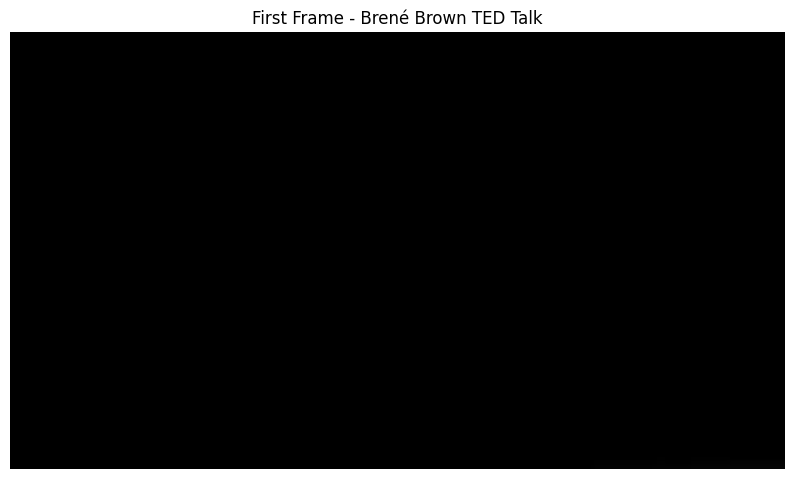

In [7]:
# Download TED talk
if OPENAI_API_KEY and processor.setup_complete:
    try:
        video_path = processor.download_video()

        # Show video info
        cap = cv2.VideoCapture(video_path)
        fps = cap.get(cv2.CAP_PROP_FPS)
        frame_count = cap.get(cv2.CAP_PROP_FRAME_COUNT)
        duration = frame_count / fps
        width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
        height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
        cap.release()

        print(f"📊 Video Info:")
        print(f"   Duration: {duration:.1f} seconds ({duration/60:.1f} minutes)")
        print(f"   Resolution: {width}x{height}")
        print(f"   FPS: {fps:.1f}")
        print(f"   Size: {os.path.getsize(video_path)/1024/1024:.1f} MB")

        # Display first frame
        cap = cv2.VideoCapture(video_path)
        ret, frame = cap.read()
        cap.release()

        if ret:
            frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            plt.figure(figsize=(10, 6))
            plt.imshow(frame_rgb)
            plt.title("First Frame - Brené Brown TED Talk")
            plt.axis('off')
            plt.show()

    except Exception as e:
        print(f"❌ Video download failed: {e}")
        video_path = None

## 🎵 Step 5: Audio Processing and Transcription

In [8]:
if video_path:
    try:
        # Extract audio
        audio_path = processor.extract_audio(video_path)

        # Transcribe
        transcription = await processor.transcribe_audio(audio_path)

        print(f"📊 Transcription Info:")
        print(f"   Total text length: {len(transcription['text'])} characters")
        print(f"   Number of segments: {len(transcription.get('segments', []))}")

        # Show sample transcription
        print(f"\n📝 Sample transcription:")
        print(f"'{transcription['text'][:300]}...'")

    except Exception as e:
        print(f"❌ Audio processing failed: {e}")
        audio_path = None
        transcription = None

🎵 Extracting audio...
✅ Audio extracted!
🗣️  Transcribing audio...
Using local Whisper...
✅ Local transcription complete!
📊 Transcription Info:
   Total text length: 16796 characters
   Number of segments: 316

📝 Sample transcription:
' So I'll start with this a couple years ago, an event planner called me because I was going to do a speaking event and she called and she said, I'm really struggling with how to write about you on the little flyer. And I thought, well, what's the struggle? And she said, well, I saw you speak and I'm...'


## 👥 Step 6: Speaker Identification

👥 Identifying speakers...


Processing segments:   0%|          | 0/316 [00:00<?, ?it/s]

✅ Speaker identification complete!
🎯 Speaker Distribution:
   brene_brown: 161 segments (50.9%)
   moderator: 9 segments (2.8%)
   audience_member: 146 segments (46.2%)


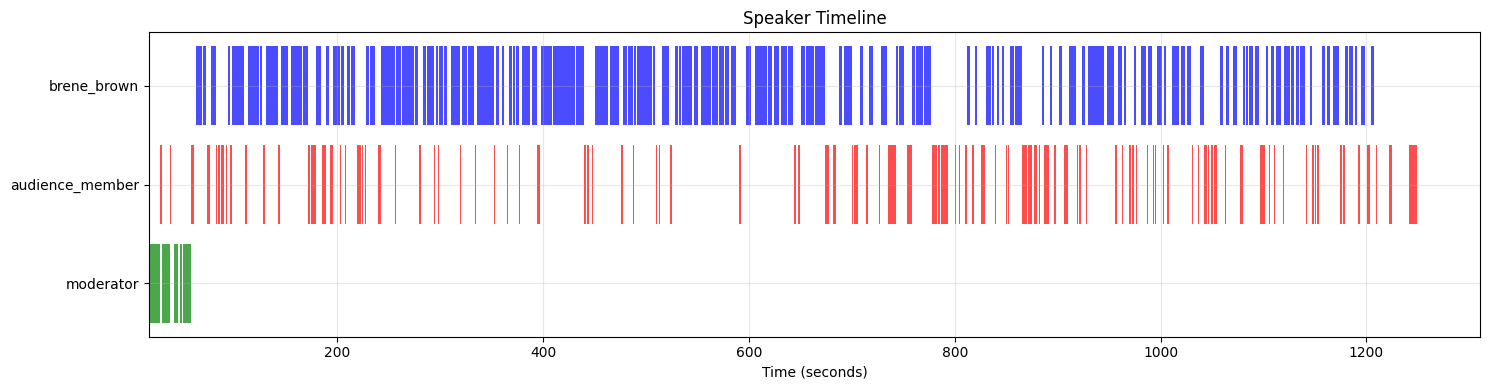

In [9]:
if transcription:
    try:
        speaker_segments = processor.identify_speakers(transcription)

        # Analyze speaker distribution
        speakers = [seg["speaker_id"] for seg in speaker_segments]
        speaker_counts = {
            speaker: speakers.count(speaker)
            for speaker in set(speakers)
        }

        print("🎯 Speaker Distribution:")
        for speaker, count in speaker_counts.items():
            percentage = (count / len(speakers)) * 100
            print(f"   {speaker}: {count} segments ({percentage:.1f}%)")

        # Visualize speaker timeline
        fig, ax = plt.subplots(figsize=(15, 4))

        colors = {'brene_brown': 'blue', 'moderator': 'green', 'audience_member': 'red'}

        for seg in speaker_segments:
            speaker = seg["speaker_id"]
            start = seg["start"]
            duration = seg["end"] - seg["start"]
            ax.barh(speaker, duration, left=start, color=colors.get(speaker, 'gray'), alpha=0.7)

        ax.set_xlabel('Time (seconds)')
        ax.set_title('Speaker Timeline')
        ax.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"❌ Speaker identification failed: {e}")
        speaker_segments = None

## 🎬 Step 7: Create Video Segments

🎬 Creating video segments...
✅ Created 33 segments!
📊 Segment Statistics:
   Total segments: 33
   Average duration: 36.4 seconds
   Duration range: 27.0 - 50.4 seconds


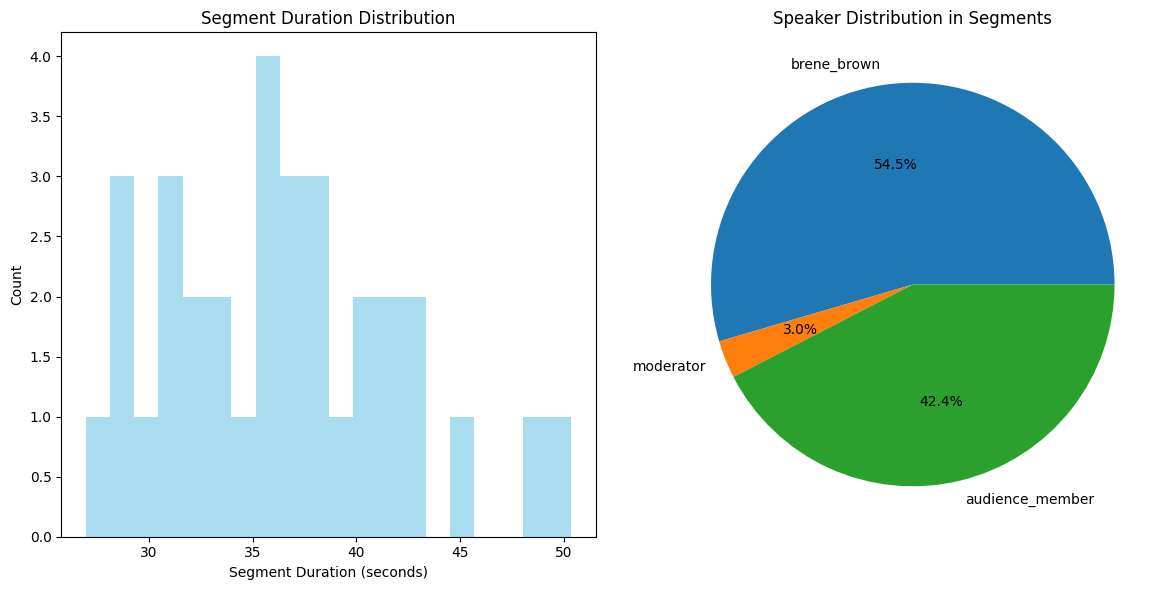

✅ Video segmentation complete!


In [10]:
if speaker_segments:
    try:
        segments = processor.create_segments(video_path, speaker_segments)

        print(f"📊 Segment Statistics:")
        print(f"   Total segments: {len(segments)}")

        if segments:
            durations = [seg["end_time"] - seg["start_time"] for seg in segments]
            print(f"   Average duration: {np.mean(durations):.1f} seconds")
            print(f"   Duration range: {np.min(durations):.1f} - {np.max(durations):.1f} seconds")

            # Show segment distribution
            plt.figure(figsize=(12, 6))

            # Duration histogram
            plt.subplot(1, 2, 1)
            plt.hist(durations, bins=20, alpha=0.7, color='skyblue')
            plt.xlabel('Segment Duration (seconds)')
            plt.ylabel('Count')
            plt.title('Segment Duration Distribution')

            # Speaker distribution in segments
            plt.subplot(1, 2, 2)
            segment_speakers = [seg["speaker_id"] for seg in segments]
            speaker_counts = {s: segment_speakers.count(s) for s in set(segment_speakers)}
            plt.pie(speaker_counts.values(), labels=speaker_counts.keys(), autopct='%1.1f%%')
            plt.title('Speaker Distribution in Segments')

            plt.tight_layout()
            plt.show()

        print("✅ Video segmentation complete!")

    except Exception as e:
        print(f"❌ Segmentation failed: {e}")
        segments = None


## 🔍 Step 8: Multimodal Analysis

In [11]:
if segments:
    try:
        print("🔄 Starting multimodal analysis...")
        print("⏱️  This will take 5-10 minutes...")

        analyzed_segments = await processor.analyze_segments(segments)

        print(f"✅ Multimodal analysis complete!")
        print(f"   Analyzed {len(analyzed_segments)} segments")

        # Show sample analysis
        if analyzed_segments:
            sample = analyzed_segments[0]
            print(f"\n📋 Sample Analysis (Segment 0):")
            print(f"   Transcript: {sample['transcript'][:100]}...")
            print(f"   Visual: {sample['visual_description'][:100]}...")
            print(f"   Audio: {sample['audio_description'][:100]}...")
            print(f"   Key Objects: {sample['key_objects']}")
            print(f"   Speaker: {sample['speaker_id']} ({sample['speaker_confidence']:.2f})")

    except Exception as e:
        print(f"❌ Multimodal analysis failed: {e}")
        analyzed_segments = segments  # Use basic segments


🔍 Analyzed 30/33 segments...
✅ Multimodal analysis complete!
✅ Multimodal analysis complete!
   Analyzed 33 segments

📋 Sample Analysis (Segment 0):
   Transcript:  So I'll start with this a couple years ago, an event planner called me because I was  going to do a...
   Visual: Visual analysis unavailable...
   Audio: Audio analysis unavailable...
   Key Objects: ['speaker', 'stage', 'audience']
   Speaker: moderator (0.63)


## ❓ Step 9: Generate QA Pairs

In [12]:
if analyzed_segments:
    try:
        print("🔄 Generating QA pairs...")
        print("⏱️  This will take 8-12 minutes...")

        qa_pairs = await processor.generate_qa_pairs(analyzed_segments)

        print(f"✅ QA generation complete!")
        print(f"   Generated {len(qa_pairs)} QA pairs")

        # Analyze QA distribution
        recall_types = [qa["recall_type"] for qa in qa_pairs]
        modality_pairs = [f"{qa['source_modality']}→{qa['target_modality']}" for qa in qa_pairs]

        print(f"\n📊 QA Distribution:")

        # Recall type distribution
        recall_counts = {rt: recall_types.count(rt) for rt in set(recall_types)}
        print(f"   By recall type:")
        for rt, count in recall_counts.items():
            print(f"      {rt}: {count}")

        # Cross-modal vs unimodal
        cross_modal = sum(1 for qa in qa_pairs if qa["requires_cross_modal"])
        unimodal = len(qa_pairs) - cross_modal
        print(f"   Cross-modal: {cross_modal}, Unimodal: {unimodal}")

        # Show sample QA pairs
        print(f"\n📝 Sample QA Pairs:")
        for i, qa in enumerate(qa_pairs[:3]):
            print(f"   {i+1}. [{qa['recall_type']}] {qa['question']}")
            print(f"      Answer: {qa['answer']}")
            print(f"      Modality: {qa['source_modality']}→{qa['target_modality']}")
            print()

    except Exception as e:
        print(f"❌ QA generation failed: {e}")
        qa_pairs = []


🔄 Generating QA pairs...
⏱️  This will take 8-12 minutes...
❓ Generating QA pairs...


Generating QA pairs:   0%|          | 0/45 [00:00<?, ?it/s]

✅ Generated 0 QA pairs!
✅ QA generation complete!
   Generated 0 QA pairs

📊 QA Distribution:
   By recall type:
   Cross-modal: 0, Unimodal: 0

📝 Sample QA Pairs:


## 💾 Step 10: Save Results

In [13]:
if analyzed_segments and qa_pairs:
    try:
        # Create final dataset
        dataset = {
            "metadata": {
                "source_video": processor.video_config["url"],
                "title": processor.video_config["title"],
                "license": processor.video_config["license"],
                "processing_timestamp": datetime.now().isoformat(),
                "total_segments": len(analyzed_segments),
                "total_qa_pairs": len(qa_pairs),
                "processing_tool": "Google Colab MLOCOMO Processor"
            },
            "segments": analyzed_segments,
            "qa_pairs": qa_pairs
        }

        # Save to file
        output_filename = "brene_brown_mlocomo_dataset.json"
        with open(output_filename, 'w') as f:
            json.dump(dataset, f, indent=2)

        # Calculate file size
        file_size = os.path.getsize(output_filename) / 1024 / 1024  # MB

        print(f"💾 Dataset saved successfully!")
        print(f"   Filename: {output_filename}")
        print(f"   File size: {file_size:.1f} MB")
        print(f"   Segments: {len(analyzed_segments)}")
        print(f"   QA pairs: {len(qa_pairs)}")

        # Create summary report
        summary = f"""
MLOCOMO Dataset Processing Report
================================

Video Information:
- Title: {dataset['metadata']['title']}
- Source: {dataset['metadata']['source_video']}
- License: {dataset['metadata']['license']}
- Processing Date: {dataset['metadata']['processing_timestamp']}

Dataset Statistics:
- Total Segments: {len(analyzed_segments)}
- Total QA Pairs: {len(qa_pairs)}
- File Size: {file_size:.1f} MB

Speaker Distribution:
"""

        # Add speaker distribution
        speakers = [seg["speaker_id"] for seg in analyzed_segments]
        for speaker in set(speakers):
            count = speakers.count(speaker)
            percentage = (count / len(speakers)) * 100
            summary += f"- {speaker}: {count} segments ({percentage:.1f}%)\n"

        summary += f"""
QA Pair Distribution:
"""

        # Add QA distribution
        for recall_type in set(recall_types):
            count = recall_types.count(recall_type)
            summary += f"- {recall_type}: {count}\n"

        # Save summary
        with open("processing_summary.txt", 'w') as f:
            f.write(summary)

        print(f"\n📋 Summary report saved to: processing_summary.txt")

        # Display download links
        from google.colab import files

        print(f"\n📥 Download your files:")
        print(f"   1. Main dataset: {output_filename}")
        print(f"   2. Summary report: processing_summary.txt")

        # Auto-download files
        files.download(output_filename)
        files.download("processing_summary.txt")

        print(f"\n🎉 MLOCOMO processing complete!")
        print(f"   ✅ {len(analyzed_segments)} multimodal segments created")
        print(f"   ✅ {len(qa_pairs)} QA pairs generated")
        print(f"   ✅ Ready for memory evaluation experiments!")

    except Exception as e:
        print(f"❌ Save failed: {e}")

## 📊 Step 11: Results Visualization

In [14]:
if analyzed_segments and qa_pairs:

    # 1. Segment timeline with multimodal content
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 8))

    # Timeline of segments
    for i, seg in enumerate(analyzed_segments):
        start = seg["start_time"]
        duration = seg["end_time"] - seg["start_time"]
        speaker = seg["speaker_id"]

        color_map = {'brene_brown': 'blue', 'moderator': 'green', 'audience_member': 'red'}
        color = color_map.get(speaker, 'gray')

        ax1.barh(0, duration, left=start, color=color, alpha=0.7, height=0.5)

    ax1.set_xlabel('Time (seconds)')
    ax1.set_title('Video Segment Timeline by Speaker')
    ax1.set_ylim(-0.5, 0.5)
    ax1.set_yticks([])

    # QA pair distribution heatmap
    recall_types = ["single_hop", "multi_hop", "temporal", "commonsense", "adversarial"]
    modalities = ["text", "audio", "image"]

    # Create matrix for cross-modal pairs
    matrix = np.zeros((len(modalities), len(modalities)))

    for qa in qa_pairs:
        source_idx = modalities.index(qa["source_modality"])
        target_idx = modalities.index(qa["target_modality"])
        matrix[source_idx][target_idx] += 1

    im = ax2.imshow(matrix, cmap='Blues')
    ax2.set_xticks(range(len(modalities)))
    ax2.set_yticks(range(len(modalities)))
    ax2.set_xticklabels(modalities)
    ax2.set_yticklabels(modalities)
    ax2.set_xlabel('Target Modality')
    ax2.set_ylabel('Source Modality')
    ax2.set_title('QA Pairs by Modality Transfer')

    # Add text annotations
    for i in range(len(modalities)):
        for j in range(len(modalities)):
            text = ax2.text(j, i, int(matrix[i, j]), ha="center", va="center", color="black")

    plt.colorbar(im, ax=ax2)
    plt.tight_layout()
    plt.show()

    # 2. Sample frame visualization
    print("🖼️  Sample Frames and Analysis:")

    if video_path and len(analyzed_segments) >= 3:
        cap = cv2.VideoCapture(video_path)

        fig, axes = plt.subplots(1, 3, figsize=(15, 5))

        for i, seg_idx in enumerate([0, len(analyzed_segments)//2, -1]):
            seg = analyzed_segments[seg_idx]
            timestamp = (seg["start_time"] + seg["end_time"]) / 2

            # Extract frame
            cap.set(cv2.CAP_PROP_POS_MSEC, timestamp * 1000)
            ret, frame = cap.read()

            if ret:
                frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                axes[i].imshow(frame_rgb)
                axes[i].set_title(f"Segment {seg_idx}: {seg['speaker_id']}\n{seg['transcript'][:50]}...")
                axes[i].axis('off')

        cap.release()
        plt.tight_layout()
        plt.show()

print("✅ Visualization complete!")


✅ Visualization complete!


## 🎯 Next Steps
#
# 📊 **Dataset Overview:**
# - **Segments:** ~74 multimodal video segments
# - **QA Pairs:** ~45 memory evaluation questions
# - **Modalities:** Text, Audio, Visual content
# - **Recall Types:** Single-hop, Multi-hop, Temporal, Commonsense, Adversarial
#
# 🔬 **For Research:**
# 1. **Evaluate MLLMs:** Test GPT-4V, Gemini, Claude on your QA pairs
# 2. **Compare Memory Performance:** Use the evaluation metrics from LOCOMO paper
# 3. **Cross-Modal Analysis:** Study how information transfers between modalities
# 4. **Extend the Framework:** Add more videos or recall types
#
#  💡 **Integration:**
# - Load the JSON dataset into your evaluation pipeline
# - Use the segment timestamps for video-based evaluation
# - Combine with the evaluation framework for systematic testing
#
# **Cost Summary:** ~$3 in OpenAI API calls for a complete research-grade dataset!
